In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_train = """C:/Users/mahmo/Documents/Ooredoo Technical test/data/ML-MATT-CompetitionQT2021_train.csv"""
df = pd.read_csv(file_train,sep=";")

In [5]:
#df = pd.read_csv(file_train,sep=";")
#df["temp_Time"] = pd.to_datetime(df["Time"],format="%H:%M")
#df = df.sort_values(["CellName","temp_Time"])
#df["day"] = df.groupby(["CellName", "Time"]).cumcount()
#df[["CellName","temp_Time","Time","day"]]

C:\Users\mahmo\AppData\Local\Temp\ipykernel_27192\4067974824.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_one_cell_with_added_dates = df_one_cell.asfreq("15T")


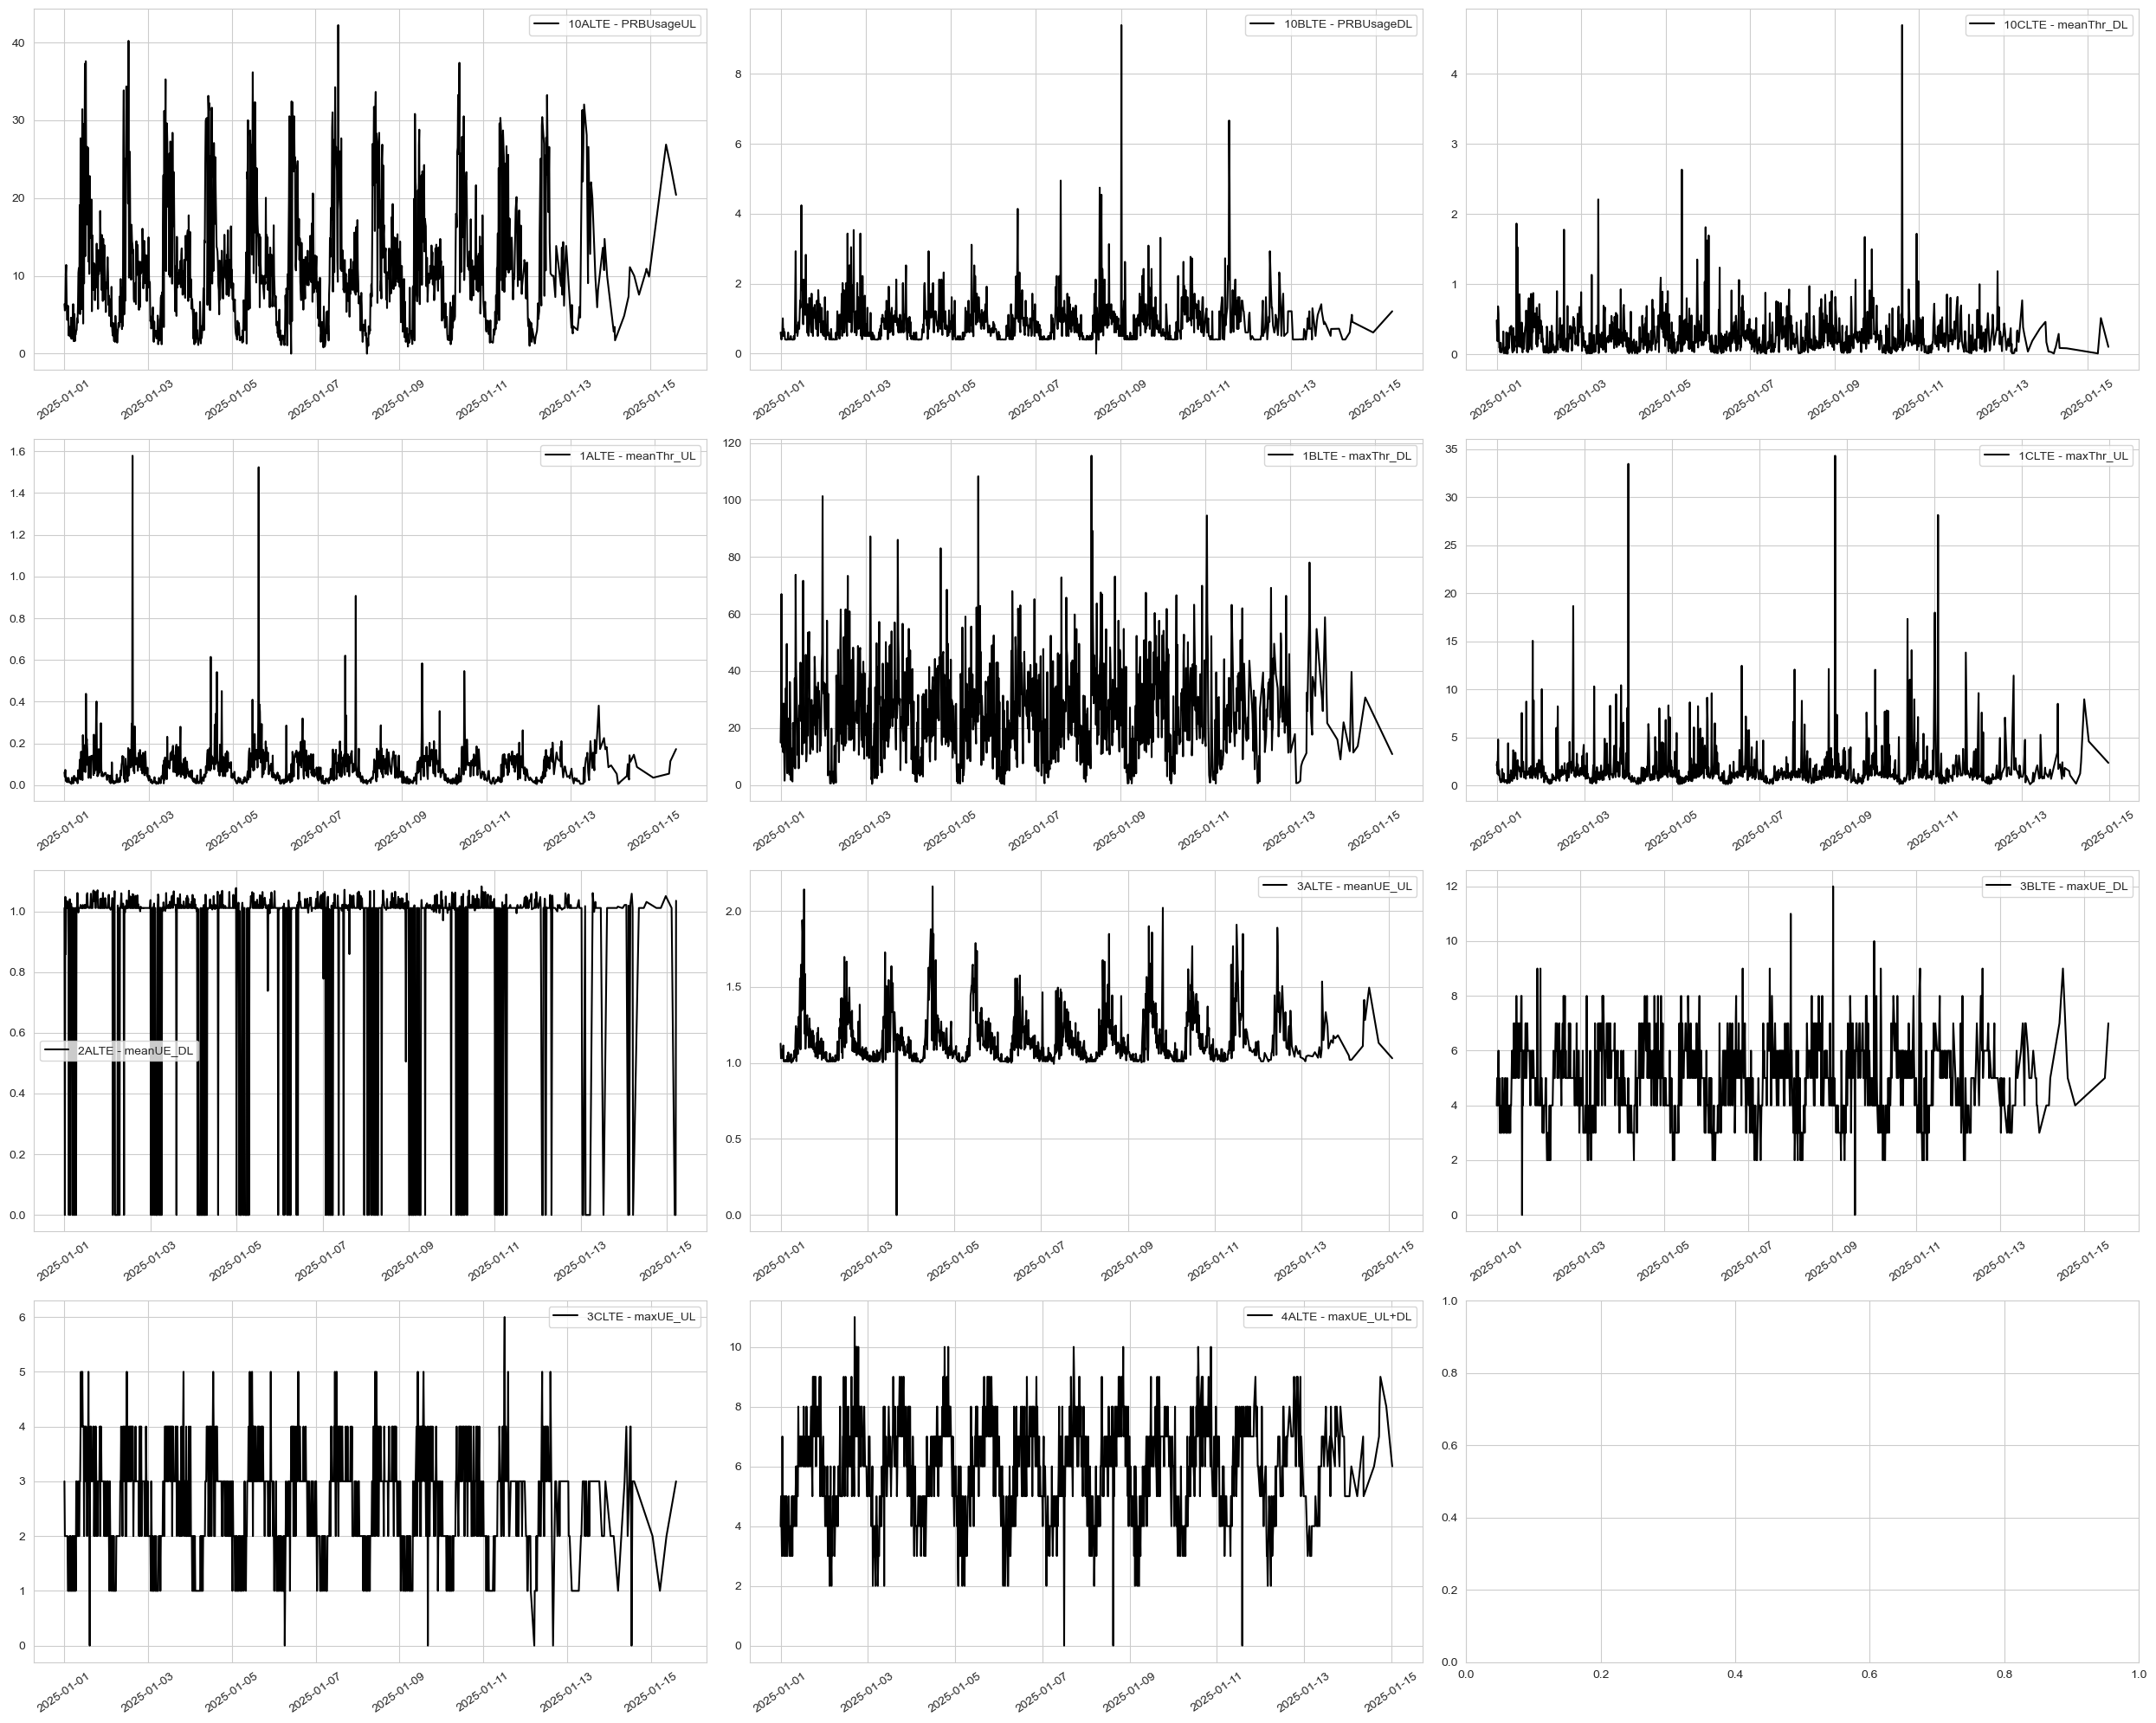

In [18]:
df = pd.read_csv(file_train,sep=";")
df["temp_Time"] = pd.to_datetime(df["Time"],format="%H:%M")
df = df.sort_values(["CellName","temp_Time"])
df["day"] = df.groupby(["CellName", "Time"]).cumcount()
df["datetime"] = pd.to_datetime("2025-01-01")+ \
                 pd.to_timedelta(df["day"],unit="D")+ \
                 pd.to_timedelta(df["temp_Time"].dt.hour*60+
                 df["temp_Time"].dt.minute,unit="m")
df.drop(columns=["Time","temp_Time","day", "Unusual"], inplace=True)

kpis = ['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL',
       'meanThr_UL', 'maxThr_DL', 'maxThr_UL',
        'meanUE_DL', 'meanUE_UL','maxUE_DL',
        'maxUE_UL', 'maxUE_UL+DL']

gps = [gp[1] for gp in df.groupby("CellName")]

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(25,20))
axes= axes.flatten()[:len(kpis)]
for j, ax in enumerate(axes):
    df_one_cell = gps[j]

    df_one_cell = df_one_cell.sort_values(by='datetime')
    df_one_cell.set_index("datetime",inplace=True,drop=True)
    df_one_cell_with_added_dates = df_one_cell.asfreq("15T")
    df_one_cell_with_added_dates[kpis[j]] = \
        df_one_cell_with_added_dates[kpis[j]].interpolate(method='linear')
    ax.plot(df_one_cell_with_added_dates.index,df_one_cell_with_added_dates[kpis[j]],color="k",
            label="""{cellname} - {kpi_name}""".format(kpi_name=kpis[j],
                                                    cellname = df_one_cell["CellName"].values[0]))
    ax.tick_params(axis='x', rotation=35)
    ax.legend(loc='best')


plt.tight_layout()
plt.show()

In [80]:
df = pd.read_csv(file_train,sep=";")
df["temp_Time"] = pd.to_datetime(df["Time"],format="%H:%M")
df = df.sort_values(["CellName","temp_Time"])
df["day"] = df.groupby(["CellName", "Time"]).cumcount()
df["datetime"] = pd.to_datetime("2025-01-01")+ \
                 pd.to_timedelta(df["day"],unit="D")+ \
                 pd.to_timedelta(df["temp_Time"].dt.hour*60+
                 df["temp_Time"].dt.minute,unit="m")
df["datetime_after_24h"] = df["datetime"] + pd.Timedelta(hours=24)
df_after_24h = df[["CellName", "datetime", "Unusual"]].copy()
df_after_24h.rename(columns={"datetime": "datetime_after_24h",
                            " 'Unusual'": "Unusual_after_24h"}, inplace=True)
df_merged = df.merge(df_after_24h, on=["CellName", "datetime_after_24h"], how="left")
df_merged.rename(columns={"Unusual_y":"target"},inplace=True)
df_merged.drop(columns=["Time","day","temp_Time", "Unusual_x","datetime_after_24h"], inplace=True)
df_merged = df_merged[~df_merged["target"].isna()]
df_merged.reset_index(inplace=True,drop=True)

In [81]:
metrics = ['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL', 'meanThr_UL',
           'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL', 'maxUE_DL',
           'maxUE_UL', 'maxUE_UL+DL']

# adding window rolling metrics
for metric in metrics:
    df_merged["{m}_mean_rolling1h".format(m=metric)] = (
        df_merged.groupby("CellName")[metric]
        .transform(lambda x: x.rolling(window=4, min_periods=1).mean()))
    df_merged["{m}_mean_rolling5h".format(m=metric)] = (
        df_merged.groupby("CellName")[metric]
        .transform(lambda x: x.rolling(window=20, min_periods=1).mean()))
    df_merged["{m}_mean_rolling10h".format(m=metric)] = (
    df_merged.groupby("CellName")[metric]
    .transform(lambda x: x.rolling(window=40, min_periods=1).mean()))

    df_merged["{m}_max_rolling1h".format(m=metric)] = (
        df_merged.groupby("CellName")[metric]
        .transform(lambda x: x.rolling(window=4, min_periods=1).max()))
    df_merged["{m}_max_rolling5h".format(m=metric)] = (
        df_merged.groupby("CellName")[metric]
        .transform(lambda x: x.rolling(window=20, min_periods=1).max()))
    df_merged["{m}_max_rolling10h".format(m=metric)] = (
        df_merged.groupby("CellName")[metric]
        .transform(lambda x: x.rolling(window=40, min_periods=1).max()))

df_merged['thr_dl_to_ul'] = df_merged["meanThr_DL"]/(df_merged["meanThr_UL"]+ 1e-6)
df_merged['ue_dl_to_ul'] = df_merged["meanUE_DL"]/(df_merged["meanUE_UL"]+ 1e-6)
df_merged['prb_dl_to_ul'] = df_merged["PRBUsageDL"]/(df_merged["PRBUsageUL"]+ 1e-6)
df_merged["hour"] = df_merged["datetime"].dt.hour
# backward fill, fill with previous valid value
df_merged = df_merged.groupby("CellName", group_keys=False).apply(lambda x: x.bfill())
df_merged.drop(columns=["CellName","datetime"], inplace=True)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_36828\341365177.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby("CellName", group_keys=False).apply(lambda x: x.bfill())


In [84]:
df_merged.isna().sum().sum()

0

In [ ]:
X = df_merged.drop(columns=["target"]).values
y = df_merged["target"].values
print(X.shape, y.shape)

model = GradientBoostingClassifier(n_estimators=100,
                                   learning_rate=0.05,
                                   max_depth=10,
                                   random_state=42)
skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=42)

f1_scores = []
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    f1_scores.append(f1)
    auc_scores.append(auc)
    print(f"  AUC: {auc:.4f}")

print(f"Avg AUC: {np.mean(auc_scores):.4f}")


#feature_importance = model.feature_importances_
# features = X.columns
#
# plt.figure(figsize=(20, 20))
# sns.barplot(x=feature_importance, y=features)
# plt.title("Feature Importances")
# plt.tight_layout()
# plt.show()


(8862, 81) (8862,)
  AUC: 0.5538
  AUC: 0.5498
  AUC: 0.5453
